In [88]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
print(keras.__version__)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from math import nan
from keras.callbacks import ModelCheckpoint

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

2.2.4
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-qchfr9gl
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-qchfr9gl
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=c4fdd27a49ff26cc8cefaec11370a1f8ab770d54497e4056160834076788a6d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-b99agnus/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
entity-annotated-corpus

time: 8.13 s (started: 2024-05-14 04:10:41 +00:00)


In [89]:
import pkg_resources

packages = ['numpy', 'pandas', 'keras', 'keras-contrib', 'tensorflow']
# Add more packages as needed

for package in packages:
    try:
        version = pkg_resources.get_distribution(package).version
        print(f"{package.capitalize()} version: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"{package.capitalize()} is not installed.")


Numpy version: 1.17.0
Pandas version: 0.25.0
Keras version: 2.2.4
Keras-contrib version: 2.0.8
Tensorflow version: 1.14.0
time: 4.36 ms (started: 2024-05-14 04:10:49 +00:00)



## Importing the dataset for named entity recognition model

In [90]:
dframe = pd.read_csv("../input/entity-annotated-corpus/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


time: 5.22 s (started: 2024-05-14 04:10:49 +00:00)


In [91]:
dframe

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O
5,5,through,london,to,TO,lowercase,to,NNP,capitalized,London,...,have,VBP,lowercase,have,lowercase,marched,1.0,lowercase,through,O
6,6,london,to,protest,VB,lowercase,protest,TO,lowercase,to,...,march,VBN,lowercase,marched,lowercase,through,1.0,capitalized,London,B-geo
7,7,to,protest,the,DT,lowercase,the,VB,lowercase,protest,...,through,IN,lowercase,through,capitalized,London,1.0,lowercase,to,O
8,8,protest,the,war,NN,lowercase,war,DT,lowercase,the,...,london,NNP,capitalized,London,lowercase,to,1.0,lowercase,protest,O
9,9,the,war,in,IN,lowercase,in,NN,lowercase,war,...,to,TO,lowercase,to,lowercase,protest,1.0,lowercase,the,O


time: 1.29 s (started: 2024-05-14 04:10:54 +00:00)


## Data preprocessing

In [92]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.93 s (started: 2024-05-14 04:10:55 +00:00)


In [93]:
dframe.columns

Index(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')

time: 3.5 ms (started: 2024-05-14 04:11:01 +00:00)


## We want word, pos, sentence_idx and tag as an input 

In [94]:
dataset=dframe.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word',"pos"],axis=1)

time: 49.8 ms (started: 2024-05-14 04:11:01 +00:00)


In [95]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 4 columns):
sentence_idx    1050794 non-null float64
shape           1050794 non-null object
word            1050794 non-null object
tag             1050794 non-null object
dtypes: float64(1), object(3)
memory usage: 32.1+ MB
time: 292 ms (started: 2024-05-14 04:11:01 +00:00)


In [96]:
dataset = pd.read_parquet("https://github.com/alwanrahmanas/ner/blob/main/labeled/bilstm/BUS%20386%20data.parquet?raw=true")

#dataset = dataset.fillna(method="ffill")
dataset.head(100)

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:707: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:734: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,Sentence #,Word,POS,Tag
0,Sentence: 1,Berdasarkan,O,O
1,Sentence: 1,uji,B,B-METODE
2,Sentence: 1,validitas,I,I-METODE
3,Sentence: 1,",",O,O
4,Sentence: 1,package,O,O
5,Sentence: 1,R,O,O
6,Sentence: 1,yang,O,O
7,Sentence: 1,dengan,O,O
8,Sentence: 1,metode,O,O
9,Sentence: 1,SGSTAR.,O,O


time: 503 ms (started: 2024-05-14 04:11:02 +00:00)


In [97]:
dataset.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Berdasarkan,O,O
1,Sentence: 1,uji,B,B-METODE
2,Sentence: 1,validitas,I,I-METODE
3,Sentence: 1,",",O,O
4,Sentence: 1,package,O,O


time: 12.4 ms (started: 2024-05-14 04:11:02 +00:00)


In [98]:
# dataset=dataset.drop(['shape'],axis=1)

time: 491 µs (started: 2024-05-14 04:11:02 +00:00)


In [99]:
if 'POS' in dataset.columns:
    dataset.drop(['POS'], axis=1, inplace=True)

time: 8.95 ms (started: 2024-05-14 04:11:02 +00:00)


In [100]:
dataset['Word'] = dataset['Word'].str.lower()

time: 35.4 ms (started: 2024-05-14 04:11:02 +00:00)


## Create list of list of tuples to differentiate each sentence from each other

In [101]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                            s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)

        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped.get("Sentence: {}".format(self.n_sent), None)
            if s is not None:
                self.n_sent += 1
            return s
        except:
            return None

time: 2.75 ms (started: 2024-05-14 04:11:02 +00:00)


In [102]:
getter = SentenceGetter(dataset)

time: 82.3 ms (started: 2024-05-14 04:11:02 +00:00)


In [103]:
sentences = getter.sentences

time: 5.41 ms (started: 2024-05-14 04:11:02 +00:00)


In [104]:
print(sentences[5])

[('dan', 'O'), ('hubungan', 'O'), ('kelembagaan.', 'O'), ('proses', 'O'), ('rekapitulasi', 'O'), ('dan', 'O'), ('pelaporan', 'O'), ('disusun', 'O'), ('secara', 'O'), ('manual', 'O'), ('menggunakan', 'O'), ('microsoft', 'O'), ('excel', 'O'), ('dikarenakan', 'O'), ('terdapat', 'O'), ('masalah', 'O'), ('pada', 'O'), ('sistem', 'O'), ('informasi', 'O'), ('kerja', 'O'), ('sama', 'O'), ('protokol', 'O'), ('dan', 'O'), ('penyiapan', 'O'), ('materi', 'O'), ('pimpinan', 'O'), ('(', 'O'), ('si-kspm', 'O'), (')', 'O'), ('.', 'O'), ('masalah', 'B-TUJUAN'), ('yang', 'I-TUJUAN'), ('terdapat', 'I-TUJUAN'), ('dalam', 'I-TUJUAN'), ('sistem', 'I-TUJUAN'), ('berjalan', 'I-TUJUAN'), ('yaitu', 'I-TUJUAN'), ('hasil', 'I-TUJUAN'), ('rekapitulasi', 'I-TUJUAN'), ('mou-pks', 'I-TUJUAN'), ('yang', 'I-TUJUAN'), ('terdapat', 'I-TUJUAN'), ('pada', 'I-TUJUAN'), ('sistem', 'I-TUJUAN'), ('berjalan', 'I-TUJUAN'), ('tidak', 'I-TUJUAN'), ('sesuai', 'I-TUJUAN'), ('dengan', 'I-TUJUAN'), ('kebutuhan', 'I-TUJUAN'), ('laporan

In [105]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 481
time: 6.67 ms (started: 2024-05-14 04:11:02 +00:00)


In [106]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

time: 5.11 ms (started: 2024-05-14 04:11:02 +00:00)


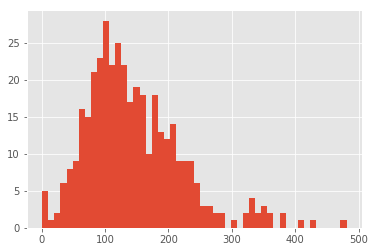

time: 352 ms (started: 2024-05-14 04:11:02 +00:00)


In [107]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [108]:
dataset["Word"]

0        berdasarkan
1                uji
2          validitas
3                  ,
4            package
            ...     
56139          lebih
56140          dalam
56141        terkait
56142       hubungan
56143      interaksi
Name: Word, Length: 56144, dtype: object

time: 4.85 ms (started: 2024-05-14 04:11:03 +00:00)


In [109]:
words = list(set(dataset["Word"].values))
words.append("ENDPAD")

time: 11.1 ms (started: 2024-05-14 04:11:03 +00:00)


In [110]:
n_words = len(words); n_words

6159

time: 6.09 ms (started: 2024-05-14 04:11:03 +00:00)


## Fix the tags

In [111]:
dataset.head()

,Sentence #,Word,Tag
0,Sentence: 1,berdasarkan,O
1,Sentence: 1,uji,B-METODE
2,Sentence: 1,validitas,I-METODE
3,Sentence: 1,",",O
4,Sentence: 1,package,O


time: 8.25 ms (started: 2024-05-14 04:11:03 +00:00)


In [112]:
tags = []
for tag in set(dataset["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
print(tags)

['B-TUJUAN', 'B-TEMUAN', 'B-METODE', 'I-METODE', 'I-TEMUAN', 'O', 'I-TUJUAN']
time: 5.82 ms (started: 2024-05-14 04:11:03 +00:00)


In [113]:
n_tags = len(tags); n_tags

7

time: 7.07 ms (started: 2024-05-14 04:11:03 +00:00)


**Converting words to numbers and numbers to words**

In [114]:
from future.utils import iteritems
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

time: 5.62 ms (started: 2024-05-14 04:11:03 +00:00)


In [115]:
word2idx['nlp']

496

time: 6.13 ms (started: 2024-05-14 04:11:03 +00:00)


In [116]:
tag2idx["B-TUJUAN"]

0

time: 5.41 ms (started: 2024-05-14 04:11:03 +00:00)


In [117]:
tag2idx

{'B-TUJUAN': 0,
 'B-TEMUAN': 1,
 'B-METODE': 2,
 'I-METODE': 3,
 'I-TEMUAN': 4,
 'O': 5,
 'I-TUJUAN': 6}

time: 6.56 ms (started: 2024-05-14 04:11:03 +00:00)


In [118]:
idx2tag[5]

'O'

time: 4.27 ms (started: 2024-05-14 04:11:03 +00:00)


In [119]:
idx2tag

{0: 'B-TUJUAN',
 1: 'B-TEMUAN',
 2: 'B-METODE',
 3: 'I-METODE',
 4: 'I-TEMUAN',
 5: 'O',
 6: 'I-TUJUAN'}

time: 2.35 ms (started: 2024-05-14 04:11:03 +00:00)


In [120]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

time: 15.9 ms (started: 2024-05-14 04:11:03 +00:00)


In [121]:
np.array(X).shape

(386,)

time: 13 ms (started: 2024-05-14 04:11:03 +00:00)


In [122]:
dim=512

time: 2.74 ms (started: 2024-05-14 04:11:03 +00:00)


In [123]:
X = pad_sequences(maxlen=dim, sequences=X, padding="post",value=n_words - 1)

time: 21.6 ms (started: 2024-05-14 04:11:03 +00:00)


In [124]:
X

array([[2840,  220, 5751, ..., 6158, 6158, 6158],
       [1416, 3158,  342, ..., 6158, 6158, 6158],
       [2284, 1270, 3449, ..., 6158, 6158, 6158],
       ...,
       [3203, 4894, 4191, ..., 6158, 6158, 6158],
       [5627, 4725, 2306, ..., 6158, 6158, 6158],
       [5982, 1269, 2665, ..., 6158, 6158, 6158]], dtype=int32)

time: 5.92 ms (started: 2024-05-14 04:11:03 +00:00)


In [125]:
y_idx = [[tag2idx[w[1]] for w in s] for s in sentences]
print(sentences[100])
print(y_idx[100])

[('diambil', 'O'), ('akan', 'O'), ('lebih', 'O'), ('baik', 'O'), ('jika', 'O'), ('data', 'O'), ('yang', 'O'), ('digunakan', 'O'), ('sangat', 'O'), ('dekat', 'O'), ('dengan', 'O'), ('waktu', 'O'), ('pengambilan', 'O'), ('keputusan', 'O'), ('kebijakan.', 'O'), ('oleh', 'O'), ('karena', 'O'), ('itu', 'O'), (',', 'O'), ('diperlukan', 'B-TUJUAN'), ('teknik', 'I-TUJUAN'), ('untuk', 'I-TUJUAN'), ('melakukan', 'I-TUJUAN'), ('peramalan', 'I-TUJUAN'), ('yang', 'I-TUJUAN'), ('sangat', 'I-TUJUAN'), ('dekat', 'I-TUJUAN'), ('dengan', 'I-TUJUAN'), ('kondisi', 'I-TUJUAN'), ('terkini', 'I-TUJUAN'), ('dari', 'I-TUJUAN'), ('jumlah', 'I-TUJUAN'), ('penumpang', 'I-TUJUAN'), ('pesawat', 'I-TUJUAN'), ('yaitu', 'I-TUJUAN'), ('nowcasting.', 'I-TUJUAN'), ('salah', 'O'), ('satu', 'O'), ('sumber', 'O'), ('data', 'O'), ('yang', 'O'), ('dapat', 'O'), ('digunakan', 'O'), ('untuk', 'O'), ('nowcasting', 'O'), ('adalah', 'O'), ('data', 'O'), ('google', 'O'), ('trends.', 'O'), ('pada', 'O'), ('penelitian', 'O'), ('ini',

In [126]:
y = pad_sequences(maxlen=dim, sequences=y_idx, padding="post", value=tag2idx["O"])
print(y_idx[100])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
time: 20.5 ms (started: 2024-05-14 04:11:03 +00:00)


In [127]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

time: 11.6 ms (started: 2024-05-14 04:11:03 +00:00)


In [128]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

time: 4.34 ms (started: 2024-05-14 04:11:12 +00:00)


## Import Keras

In [129]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k

time: 887 µs (started: 2024-05-14 04:11:15 +00:00)


## Keras version

In [130]:
print(k.__version__)

2.2.4
time: 717 µs (started: 2024-05-14 04:11:16 +00:00)


## Model
 **Pay attention to the word embedding size

input = Input(shape=(dim,))
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=dim)(input)
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.05, 
                           recurrent_dropout=0.05, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  # previously softmax output layer

crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [131]:
import keras.backend as K

# Define custom loss functions
def focal_loss(y_true, y_pred, gamma=2.0):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    return -K.sum((1 - y_pred) ** gamma * y_true * K.log(y_pred), axis=-1)

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return -(2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Define custom metric function
def custom_metric(y_true, y_pred, method='focal'):
    # You can choose either Focal Loss or Dice Loss here
    if method == 'focal':
        loss = focal_loss(y_true, y_pred)
    elif method == 'dice':
        loss = dice_loss(y_true, y_pred)
    return loss



time: 3.09 ms (started: 2024-05-14 04:11:19 +00:00)


In [132]:
class CustomCRF(CRF):
    def call(self, inputs, mask=None, training=None):
        sequence_lengths = K.sum(K.cast(mask, 'int32'), axis=-1)
        self.sequence_lengths = sequence_lengths  # Store it for later use
        return super(CustomCRF, self).call(inputs, mask=mask, training=training)


time: 1.46 ms (started: 2024-05-14 04:11:20 +00:00)


In [133]:
n_tags

7

time: 2.46 ms (started: 2024-05-14 04:11:21 +00:00)


In [134]:
# Define your model
# Define your model
input = Input(shape=(dim,))
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=dim)(input)
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.05, 
                           recurrent_dropout=0.05, 
                           kernel_initializer='he_normal'))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer='he_normal')(model)
output = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # Softmax output layer




time: 2.2 s (started: 2024-05-14 04:11:22 +00:00)


In [135]:
# Define your model
model = Model(input, output)

time: 858 µs (started: 2024-05-14 04:11:24 +00:00)


In [136]:
adam = k.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
# #model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])
# # Compile the model with custom loss
# model = Model(input, out)
# Compile the model with custom loss and accuracy metric
# Compile the model with custom loss and custom metric
model.compile(optimizer=adam, loss=custom_metric, metrics=[custom_metric])


time: 47.3 ms (started: 2024-05-14 04:11:25 +00:00)


In [137]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 512, 300)          1847700   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512, 600)          1442400   
_________________________________________________________________
lstm_4 (LSTM)                (None, 512, 600)          2882400   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 512, 7)            4207      
Total params: 6,176,707
Trainable params: 6,176,707
Non-trainable params: 0
_________________________________________________________________
time: 2.45 ms (started: 2024-05-14 04:11:27 +00:00)


model

In [138]:
from tensorflow.keras.utils import plot_model

time: 785 µs (started: 2024-05-14 04:11:30 +00:00)


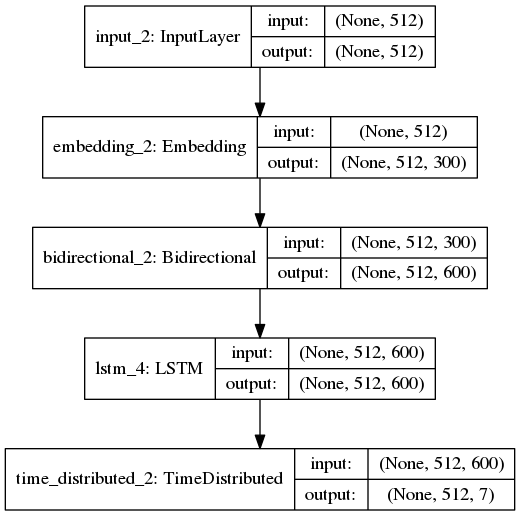

time: 102 ms (started: 2024-05-14 04:11:35 +00:00)


In [139]:
# Assuming 'model' is your Keras model
plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)

## Save the model after each epoch if validation is better

In [141]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# Define a custom callback to calculate validation accuracy
class ValidationAccuracy(Callback):
    def __init__(self, filepath):
        super(ValidationAccuracy, self).__init__()
        self.filepath = filepath
        
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        val_loss = logs.get('val_loss')
        if val_loss is None:
            return
        val_acc = 1 - val_loss  # Assuming higher val_loss means lower accuracy (change this if it's the opposite)
        logs['val_acc'] = val_acc

# Define the file path with the dynamic name
filepath = "ner-bi-lstm-td-model-{epoch:02d}-{val_acc:.2f}.hdf5"

# Create the custom callback instance
val_accuracy_callback = ValidationAccuracy(filepath)

# Create the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_acc', 
                               patience=10, 
                               verbose=1, 
                               mode='max', 
                               restore_best_weights=True)

# Use the callbacks in the training loop
callbacks_list = [val_accuracy_callback, checkpoint, early_stopping]


time: 3.5 ms (started: 2024-05-14 04:11:48 +00:00)


In [ ]:
# <!-- from sklearn.model_selection import KFold

# # Define the number of folds for cross-validation
# n_splits = 3  # for example, you can adjust this number as needed

# # Initialize KFold cross-validator
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Initialize lists to store training/validation histories
# training_histories = []
# validation_histories = []

# # Convert y_train to a NumPy array if it's not already one
# y_train_array = np.array(y_train)

# # Perform cross-validation
# for train_index, val_index in kf.split(X_train):
#     X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
#     y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index] -->

#     # Fit the model on the current fold
#     history = model.fit(X_train_fold, np.array(y_train_fold), batch_size=16, epochs=5, 
#                         validation_data=(X_val_fold, np.array(y_val_fold)), verbose=1, 
#                         callbacks=callbacks_list)
    
#     # Store training/validation history
#     training_histories.append(history.history['crf_viterbi_accuracy'])  # Use 'crf_viterbi_accuracy' instead of 'accuracy'
#     validation_histories.append(history.history['val_crf_viterbi_accuracy'])  # Use 'val_crf_viterbi_accuracy' instead of 'val_accuracy'



In [ ]:
# # Assuming X_train is your tokenized and padded input data
# print("Shape of X_train:", X_train.shape)

# # Assuming n_tags is the number of unique tags
# print("Number of unique tags (classes):", n_tags)

# # Confirm the last dimension of X_train matches the number of classes
# assert X_train.shape[-1] == n_tags, "Mismatch between the last dimension of X_train and the number of classes (n_tags)"


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define the number of folds for cross-validation
n_splits = 9  # Adjust this number as needed

# Convert y_train to a NumPy array if it's not already one
y_train_array = np.array(y_train)

# Initialize KFold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store training/validation histories
training_histories = []
validation_histories = []

# Perform cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]

    # Fit the model on the current fold
    history = model.fit(X_train_fold, np.array(y_train_fold), batch_size=32, epochs=100, 
                        validation_data=(X_val_fold, np.array(y_val_fold)), verbose=1, 
                        callbacks=callbacks_list)
    
    # Store training/validation history
    training_histories.append(history.history['custom_metric'])  # Use the name of your custom metric function
    validation_histories.append(history.history['val_custom_metric'])  # Use the name of your custom metric function

# Plotting the loss for each fold
plt.figure(figsize=(12, 8))

# Plot training loss for each fold
for i, training_loss in enumerate(training_histories):
    plt.plot(training_loss, label=f'Training Fold {i+1}')
    
# Plot validation loss for each fold
for i, validation_loss in enumerate(validation_histories):
    plt.plot(validation_loss, label=f'Validation Fold {i+1}', linestyle='--')

plt.title('Training and Validation Loss for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Train on 273 samples, validate on 35 samples
Epoch 1/100
273/273 [==============================] - 32s 117ms/step - loss: 0.9192 - custom_metric: 0.9192 - val_loss: 0.4841 - val_custom_metric: 0.4841

Epoch 00001: val_acc improved from -inf to 0.51592, saving model to ner-bi-lstm-td-model-01-0.52.hdf5
Epoch 2/100
273/273 [==============================] - 24s 87ms/step - loss: 0.3928 - custom_metric: 0.3928 - val_loss: 0.3807 - val_custom_metric: 0.3807

Epoch 00002: val_acc improved from 0.51592 to 0.61932, saving model to ner-bi-lstm-td-model-02-0.62.hdf5
Epoch 3/100
 64/273 [======>.......................] - ETA: 16s - loss: 0.3250 - custom_metric: 0.3250

## Accumulate metrics by tag 

In [ ]:
tag2idx

In [ ]:
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1


In [ ]:
TP

## Single prediction and verbose results

In [ ]:
i = 3
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
gt = np.argmax(y_test[i], axis=-1)
print(gt)
print("{:14}: ({:5}): {}".format("Word", "True", "Pred"))
for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
    #
    print("{:14}: ({:5}): {}".format(words[w],idx2tag[gt[idx]],tags[pred]))

## Predict everything at once

In [ ]:
p = model.predict(np.array(X_train))  

## The output is 3d: sent x word x tag prob (softmax)

In [ ]:
p.shape

## Standard Classification Report

In [ ]:
from sklearn.metrics import classification_report

Grab the 3d dimension and return the index of the highest probability ... the index matches the tag value
np.argmax(p, axis=2)

In [ ]:
np.argmax(p, axis=2)[0]

In [ ]:
report=classification_report(np.argmax(y_train, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=list(idx2tag.keys()), target_names=list(idx2tag.values()))
print(report)

focal loss 256, 64, 50

              precision    recall  f1-score   support

    B-TUJUAN       0.73      0.68      0.70       197
    I-TUJUAN       0.97      0.99      0.98      3065
    I-TEMUAN       0.98      0.99      0.99     10834
    B-METODE       0.69      0.21      0.32       498
    I-METODE       0.87      0.85      0.86      1354
    B-TEMUAN       0.70      0.51      0.59       453
           O       0.99      0.99      0.99     48111

    accuracy                           0.98     64512
   macro avg       0.85      0.74      0.78     64512
weighted avg       0.98      0.98      0.98     64512

 focal loss 2 jam dim 512, epoch 100
 precision    recall  f1-score   support

    B-TUJUAN       0.85      0.85      0.85       239
    I-TUJUAN       0.99      0.99      0.99      3789
    I-TEMUAN       0.97      0.97      0.97     11325
    B-METODE       0.73      0.53      0.61       555
    I-METODE       0.91      0.91      0.91      1430
    B-TEMUAN       0.87      0.74      0.80       471
           O       0.99      1.00      0.99    111215

    accuracy                           0.99    129024
   macro avg       0.90      0.85      0.87    129024
weighted avg       0.99      0.99      0.99    129024

In [ ]:
# import numpy as np

# prec = [0.69 , 0.0, 0.00, 0, 0.15, 0.08, 0.00]
# rec = [0.97, 0, 0.00, 0, 0.0, 0.02, 0]
# f1 = [0.8, 0.0, 0.00, 0, 0.01, 0.03, 0]

# av_prec = np.mean(prec)
# av_rec = np.mean(rec)
# av_f1 = np.mean(f1)


In [ ]:
# print("Average Precision:", av_prec)
# print("Average Recall:", av_rec)
# print("Average F1-score:", av_f1)


## Accumulate the scores by tag

In [ ]:
for i, sentence in enumerate(X_test):
    y_hat = np.argmax(p[i], axis=-1)
    gt = np.argmax(y_test[i], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag[gt[idx]],tags[pred])

## How did Classification perform for each tag

In [ ]:
for tag in tag2idx.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))    

In [ ]:
# Summing all values in the dictionaries
total_TP = sum(TP.values())
total_TN = sum(TN.values())
total_FP = sum(FP.values())
total_FN = sum(FN.values())

# Printing the totals
print("Total TP:", total_TP)
print("Total TN:", total_TN)
print("Total FP:", total_FP)
print("Total FN:", total_FN)


In [ ]:
# ALL METRIC 
import math

prec= total_TP/(total_TP+total_FP)
rec = total_TP/(total_TP+total_FN)
f1=2*prec*rec/(prec+rec)

# Print the metrics
print("Precision:", round(prec,3))
print("Recall:", round(rec,3))
print("F1-score:", round(f1,3))

tanpa layer lstm tambahan:

Precision: 0.9708141321044547
Recall: 0.9210784779647055
F1-score: 0.9452925588125315